In [1]:
import traceback

import polars as pl
import sys
import torch
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from lifelines import WeibullFitter
from sklearn.model_selection import train_test_split
from torch import optim
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from models.Titans import Model
from utils.custom_losses import CustomLoss
from utils.lstf_feature_maker.piecewise_linear_regression import PiecewiseLinearRegression
from utils.lstf_feature_maker.weibull import WeibullFeatureMaker

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '../data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

tb_bas_oper_part_mst = (pl.read_parquet(DIR + 'tb_bas_oper_part_mst.parquet')
                        .select(['OPER_PART_NO', 'OPER_PART_NM'])
                        .rename({'OPER_PART_NO': 'oper_part_no', 'OPER_PART_NM': 'oper_part_nm'}))
tb_dyn_fcst_demand = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd.parquet')
                      .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                      .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                      .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))
tb_dyn_fcst_demand_sellout = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd_sellout.parquet')
                              .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                              .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                              .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
from utils.date_util import DateUtil

dyn_fcst_demand = tb_dyn_fcst_demand.with_columns([
    pl.col('demand_dt').cast(pl.Int64).map_elements(DateUtil.yyyymmdd_to_date, return_dtype = pl.Date)
])

dyn_demand_sellout = tb_dyn_fcst_demand_sellout.with_columns([
    pl.col('demand_dt').cast(pl.Int64).map_elements(DateUtil.yyyymmdd_to_date, return_dtype = pl.Date)
])

dyn_fcst_demand

shape: (1_723_020, 4)
┌───────────────┬───────────────┬────────────┬────────────┐
│ part_no       ┆ oper_part_no  ┆ demand_dt  ┆ demand_qty │
│ ---           ┆ ---           ┆ ---        ┆ ---        │
│ str           ┆ str           ┆ date       ┆ f64        │
╞═══════════════╪═══════════════╪════════════╪════════════╡
│ T4240-71102BB ┆ T4240-71102BB ┆ 2018-01-01 ┆ 3.0        │
│ T5210-34402   ┆ T5210-34402   ┆ 2018-01-01 ┆ 1.0        │
│ T5210-30081   ┆ T5210-30081   ┆ 2018-01-01 ┆ 1.0        │
│ T5210-65661   ┆ T5210-65661   ┆ 2018-01-01 ┆ 1.0        │
│ T5210-66472   ┆ T5210-66472   ┆ 2018-01-01 ┆ 1.0        │
│ …             ┆ …             ┆ …          ┆ …          │
│ U3215-52203   ┆ U3215-52203   ┆ 2024-02-05 ┆ 30.0       │
│ T5710-69252   ┆ T5710-69252   ┆ 2024-02-05 ┆ 2.0        │
│ DYD1-O07      ┆ DYD1-O07      ┆ 2024-02-05 ┆ 4.0        │
│ T2198-69775   ┆ T2198-69775   ┆ 2024-02-05 ┆ 6.0        │
│ TC26-0416B    ┆ TC26-0416B    ┆ 2024-02-05 ┆ 2.0        │
└───────────────┴───────────────┴────────────┴────────────┘

In [3]:
dyn_fcst = (dyn_fcst_demand
                .join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
                .select(['oper_part_no', 'oper_part_nm', 'demand_dt','demand_qty'])
                .sort(['oper_part_no', 'demand_dt'])
                .with_columns([
                    pl.col('demand_qty').cum_sum().over('oper_part_no').alias('cumsum_qty')
                ])
              )
dyn_demand = (dyn_demand_sellout.join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
                    .select(['oper_part_no', 'oper_part_nm', 'demand_dt', 'demand_qty'])
                    .sort(['oper_part_no', 'demand_dt'])
                    .with_columns([
                        pl.col('demand_qty').cum_sum().over('oper_part_no').alias('cumsum_qty')
                 ])
               )

In [4]:
lookback_window = 40
horizon = 20
df_grouped = (dyn_demand
                .select(['oper_part_no', 'demand_dt', 'demand_qty', 'cumsum_qty'])
                .sort(['oper_part_no', 'demand_dt'])
                .with_columns(pl.col('demand_dt').map_elements(DateUtil.date_to_yyyymm, return_dtype = pl.Int64).alias('demand_dt'))
                .select('oper_part_no', 'demand_dt', 'demand_qty')
                .group_by(['oper_part_no', 'demand_dt'])
                .agg(pl.col('demand_qty').sum().alias('demand_qty'))
                .sort(['oper_part_no', 'demand_dt'])
              )

df_grouped

shape: (867_077, 3)
┌──────────────┬───────────┬────────────┐
│ oper_part_no ┆ demand_dt ┆ demand_qty │
│ ---          ┆ ---       ┆ ---        │
│ str          ┆ i64       ┆ f64        │
╞══════════════╪═══════════╪════════════╡
│ 0001-1001    ┆ 201803    ┆ 5.0        │
│ 0001-1001    ┆ 201811    ┆ 7.0        │
│ 0001-1001    ┆ 202002    ┆ 120.0      │
│ 0001-1001    ┆ 202003    ┆ 2.0        │
│ 0001-1001    ┆ 202305    ┆ 2.0        │
│ …            ┆ …         ┆ …          │
│ ZZ90239      ┆ 202010    ┆ 1.0        │
│ ZZ90239      ┆ 202111    ┆ 1.0        │
│ ZZ90239      ┆ 202306    ┆ 1.0        │
│ ZZ90239      ┆ 202411    ┆ 1.0        │
│ ZZ90239      ┆ 202606    ┆ 1.0        │
└──────────────┴───────────┴────────────┘

In [5]:
class MultiPartTimeSeriesDataset(Dataset):
    def __init__(self, df: pl.DataFrame, lookback: int, horizon: int):
        self.samples: list[tuple[np.ndarray, np.ndarray]] = []
        self.part_ids: list[str] = []

        grouped = df.sort(['oper_part_no', 'demand_dt']).partition_by('oper_part_no')

        for df in grouped:
            part_no = df['oper_part_no'][0]
            series = df['demand_qty'].to_numpy()

            for i in range(len(series) - lookback - horizon):
                x_seq = series[i:i + lookback]
                y_seq = series[i + lookback: i + lookback + horizon]
                self.samples.append((x_seq, y_seq))
                self.part_ids.append(part_no)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_seq, y_seq = self.samples[idx]
        return torch.tensor(x_seq, dtype = torch.float32).unsqueeze(-1),torch.tensor(y_seq, dtype = torch.float32), self.part_ids[idx]

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # ✅ 전체 epochs 반영
    max_grad_norm = 30  # ✅ Gradient clipping
    patience = 50       # ✅ Early stopping patience
    best_loss = float('inf')
    counter = 0
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:  # ✅ TensorDataset → 두 개만 unpack
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            # ✅ Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # ✅ Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                pred = model(x_val)
                val_loss += loss_fn(pred, y_val).item()
        avg_val_loss = val_loss / len(val_loader)

        # ✅ Scheduler update
        scheduler.step()

        # ✅ Early Stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()  # Save best weights
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

        # ✅ Logging
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{epochs} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return model


In [7]:
from models.Titans import TestTimeMemoryManager
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# ✅ Hyperparameters
lookback = 48
horizon = 12
batch_size = 256

# ✅ Step 1: 원본 Dataset 생성
dataset = MultiPartTimeSeriesDataset(df_grouped, lookback, horizon)

# ✅ Step 2: numpy 변환 (전체 데이터)
X_list = []
y_list = []
for i in range(len(dataset)):
    x_seq, y_seq, _ = dataset[i]
    X_list.append(x_seq.numpy().flatten())  # (lookback,)
    y_list.append(y_seq.numpy().flatten())  # (horizon,)

X_array = np.array(X_list)  # shape: (num_samples, lookback)
y_array = np.array(y_list)  # shape: (num_samples, horizon)

# ✅ Step 3: Train/Test Split (numpy)
train_size = int(len(X_array) * 0.8)
X_train, X_val = X_array[:train_size], X_array[train_size:]
y_train, y_val = y_array[:train_size], y_array[train_size:]

# # ✅ Step 4: Scaling
scaler_X = RobustScaler()
scaler_y = RobustScaler()
#
# X_train_scaled = scaler_X.fit_transform(X_train)
# X_val_scaled = scaler_X.transform(X_val)
# y_train_scaled = scaler_y.fit_transform(y_train)
# y_val_scaled = scaler_y.transform(y_val)

# x_train_log = np.log1p(X_train)
# x_val_log = np.log1p(X_val)
# y_train_log = np.log1p(y_train)
# y_val_log = np.log1p(y_val)

# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

# ✅ Step 5: Tensor 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(-1)  # (samples, lookback, 1)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)

# ✅ Step 6: TensorDataset 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# ✅ Step 7: DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ✅ Step 8: Titans 모델 정의
model = Model(
    input_dim=1,
    d_model=64,
    n_layers=2,
    n_heads=4,
    d_ff=256,
    contextual_mem_size=64,
    persistent_mem_size=16,
    output_horizon=horizon
)

# ✅ Step 9: 학습
device = "cuda" if torch.cuda.is_available() else "cpu"
train_model(model, train_loader, val_loader, epochs=100, lr=1e-3, device=device)


Epoch 1/100 | LR: 0.001000 | Train Loss: 1472.0614 | Val Loss: 42.9807
Epoch 2/100 | LR: 0.000999 | Train Loss: 1443.0354 | Val Loss: 37.8105
Epoch 3/100 | LR: 0.000998 | Train Loss: 1426.3518 | Val Loss: 33.2590
Epoch 4/100 | LR: 0.000996 | Train Loss: 1408.4954 | Val Loss: 32.6593
Epoch 5/100 | LR: 0.000994 | Train Loss: 1398.1708 | Val Loss: 33.5850
Epoch 6/100 | LR: 0.000991 | Train Loss: 1392.6722 | Val Loss: 34.4352
Epoch 7/100 | LR: 0.000988 | Train Loss: 1385.4286 | Val Loss: 32.7662
Epoch 8/100 | LR: 0.000984 | Train Loss: 1379.4164 | Val Loss: 32.5777
Epoch 9/100 | LR: 0.000980 | Train Loss: 1374.3928 | Val Loss: 33.0176
Epoch 10/100 | LR: 0.000976 | Train Loss: 1370.5220 | Val Loss: 33.2386
Epoch 11/100 | LR: 0.000970 | Train Loss: 1366.7338 | Val Loss: 32.4139
Epoch 12/100 | LR: 0.000965 | Train Loss: 1362.7908 | Val Loss: 33.1904
Epoch 13/100 | LR: 0.000959 | Train Loss: 1363.9815 | Val Loss: 33.6594
Epoch 14/100 | LR: 0.000952 | Train Loss: 1357.2750 | Val Loss: 32.3568
E

Model(
  (encoder): MemoryEncoder(
    (input_proj): Linear(in_features=1, out_features=64, bias=True)
    (layers): ModuleList(
      (0-1): 2 x MemoryTransformerBlock(
        (attn): MemoryAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (out_proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): PositionWiseFFN(
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=64, out_features=12, bias=Tr

In [8]:
from sklearn.metrics import mean_squared_error

results = []
all_parts = df_grouped.select("oper_part_no").unique().to_series().to_list()
device = next(model.parameters()).device  # 모델 디바이스 확인
model.eval()
for part_id in all_parts:
    # ✅ 파트별 시계열 추출
    test_series = (
        df_grouped.filter(pl.col("oper_part_no") == part_id)
                  .sort("demand_dt")["demand_qty"].to_numpy()
    )

    # ✅ 데이터 길이 확인
    if len(test_series) < lookback + horizon:
        print(f"Skipping {part_id}: insufficient data ({len(test_series)})")
        continue

    # ✅ 입력 / 라벨 준비
    x_new = torch.tensor(test_series[-(lookback + horizon):-horizon], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    y_new = torch.tensor(test_series[-horizon:], dtype=torch.float32).unsqueeze(0)

    # ✅ 디바이스 이동
    x_new = x_new.to(device)
    y_new = y_new.to(device)

    # ✅ 예측 (TTM 적용 전)
    with torch.no_grad():
        pred_before = model(x_new)
    loss_before = mean_squared_error(y_new.cpu().numpy().flatten(), pred_before.cpu().numpy().flatten())

    # ✅ TTM (Test-Time Adaptation)
    ttm = TestTimeMemoryManager(model)
    embedded_context = model.encoder.input_proj(x_new)  # Context embedding
    ttm.add_context(embedded_context)

    loss_after_adapt = ttm.adapt(x_new, y_new, steps=3)

    # ✅ 예측 (TTM 적용 후)
    with torch.no_grad():
        pred_after = model(x_new)

    # ✅ 결과 저장
    results.append({
        "part_id": part_id,
        "loss_before": loss_before,
        "loss_after": loss_after_adapt,
        "predicted_before": pred_before.cpu().numpy().flatten().tolist(),
        "predicted_after": pred_after.cpu().numpy().flatten().tolist(),
        "actual": y_new.cpu().numpy().flatten().tolist()
    })

# ✅ Polars DataFrame 변환
results_df = pl.DataFrame(results)
print(results_df)

Skipping TB36-0299A: insufficient data (4)
Skipping T4710-87021: insufficient data (35)
Skipping 3353K002: insufficient data (2)
Skipping FTF64-11604: insufficient data (4)
Skipping T4935-45751: insufficient data (6)
Skipping F5800-12313: insufficient data (11)
Skipping UD23-84AAA: insufficient data (9)
Skipping T4810-14731: insufficient data (23)
Skipping T5815-23115: insufficient data (31)
Skipping T2185-70116: insufficient data (2)
Skipping T4835-88182: insufficient data (28)
Skipping 83202-120E-0000: insufficient data (14)
Skipping 08141-06202S: insufficient data (8)
Skipping AL77486: insufficient data (11)
Skipping 200028100: insufficient data (6)
Skipping C7220-61553: insufficient data (4)
Skipping T5525-51421: insufficient data (35)
Skipping TF19-0044A: insufficient data (5)
Skipping T4665-13522: insufficient data (23)
Skipping 400602-01049A: insufficient data (10)
Skipping 52300-4579-1: insufficient data (9)
Skipping T4816-69115: insufficient data (7)
Skipping T4818-50771: insu

In [9]:
results_df

shape: (4_656, 6)
┌──────────────┬───────────────┬──────────────┬─────────────────┬─────────────────┬────────────────┐
│ part_id      ┆ loss_before   ┆ loss_after   ┆ predicted_befor ┆ predicted_after ┆ actual         │
│ ---          ┆ ---           ┆ ---          ┆ e               ┆ ---             ┆ ---            │
│ str          ┆ f64           ┆ f64          ┆ ---             ┆ list[f64]       ┆ list[f64]      │
│              ┆               ┆              ┆ list[f64]       ┆                 ┆                │
╞══════════════╪═══════════════╪══════════════╪═════════════════╪═════════════════╪════════════════╡
│ T4601-82611  ┆ 2.680708      ┆ 138149.28125 ┆ [3.621948,      ┆ [366.606476,    ┆ [5.0, 5.0, …   │
│              ┆               ┆              ┆ 3.213284, …     ┆ 387.084412, …   ┆ 1.0]           │
│              ┆               ┆              ┆ 2.67964…        ┆ 326…            ┆                │
│ 76KP-2015-2  ┆ 2.892555e7    ┆ 2.894216e7   ┆ [377.994171,    ┆ [380.966827,    ┆ [215.0,        │
│              ┆               ┆              ┆ 404.675568, …   ┆ 411.664429, …   ┆ 6960.0, …      │
│              ┆               ┆              ┆ 343…            ┆ 356…            ┆ 80.0]          │
│ T4350-93111  ┆ 139991.640625 ┆ 144214.53125 ┆ [357.382141,    ┆ [368.300629,    ┆ [4.0, 1.0, …   │
│              ┆               ┆              ┆ 393.261932, …   ┆ 401.321167, …   ┆ 1.0]           │
│              ┆               ┆              ┆ 342…            ┆ 348…            ┆                │
│ T4682-42313  ┆ 135079.375    ┆ 111198.90625 ┆ [351.773407,    ┆ [349.936584,    ┆ [11.0, 2.0, …  │
│              ┆               ┆              ┆ 387.507599, …   ┆ 368.319183, …   ┆ 6.0]           │
│              ┆               ┆              ┆ 345…            ┆ 322…            ┆                │
│ 76KD-0186    ┆ 115988.125    ┆ 123897.6875  ┆ [364.463928,    ┆ [375.659546,    ┆ [8.0, 37.0, …  │
│              ┆               ┆              ┆ 395.784393, …   ┆ 405.500458, …   ┆ 126.0]         │
│              ┆               ┆              ┆ 345…            ┆ 340…            ┆                │
│ …            ┆ …             ┆ …            ┆ …               ┆ …               ┆ …              │
│ C9120-65012  ┆ 5822.382324   ┆ 6102.005859  ┆ [22.636135,     ┆ [28.265736,     ┆ [4.0, 56.0, …  │
│              ┆               ┆              ┆ 23.175354, …    ┆ 26.743471, …    ┆ 6.0]           │
│              ┆               ┆              ┆ 22.57…          ┆ 21.20…          ┆                │
│ 12156-6165-1 ┆ 12030.243164  ┆ 11969.763672 ┆ [64.954086,     ┆ [67.670326,     ┆ [3.0, 20.0, …  │
│              ┆               ┆              ┆ 68.236794, …    ┆ 70.496605, …    ┆ 300.0]         │
│              ┆               ┆              ┆ 60.81…          ┆ 65.93…          ┆                │
│ M1200-22023  ┆ 1030.469849   ┆ 1073.998169  ┆ [49.238251,     ┆ [33.725216,     ┆ [32.0, 6.0, …  │
│              ┆               ┆              ┆ 52.057598, …    ┆ 31.832575, …    ┆ 27.0]          │
│              ┆               ┆              ┆ 46.49…          ┆ 24.38…          ┆                │
│ T5210-82141  ┆ 140.543091    ┆ 69.95388     ┆ [15.565618,     ┆ [14.571926,     ┆ [2.0, 1.0, …   │
│              ┆               ┆              ┆ 16.26939, …     ┆ 14.362713, …    ┆ 1.0]           │
│              ┆               ┆              ┆ 12.240…         ┆ 8.785…          ┆                │
│ C7210-21413  ┆ 157.806931    ┆ 122.499863   ┆ [10.785347,     ┆ [9.540458,      ┆ [5.0, 1.0, …   │
│              ┆               ┆              ┆ 12.310152, …    ┆ 10.657192, …    ┆ 1.0]           │
│              ┆               ┆              ┆ 14.24…          ┆ 8.3869…         ┆                │
└──────────────┴───────────────┴──────────────┴─────────────────┴─────────────────┴────────────────┘

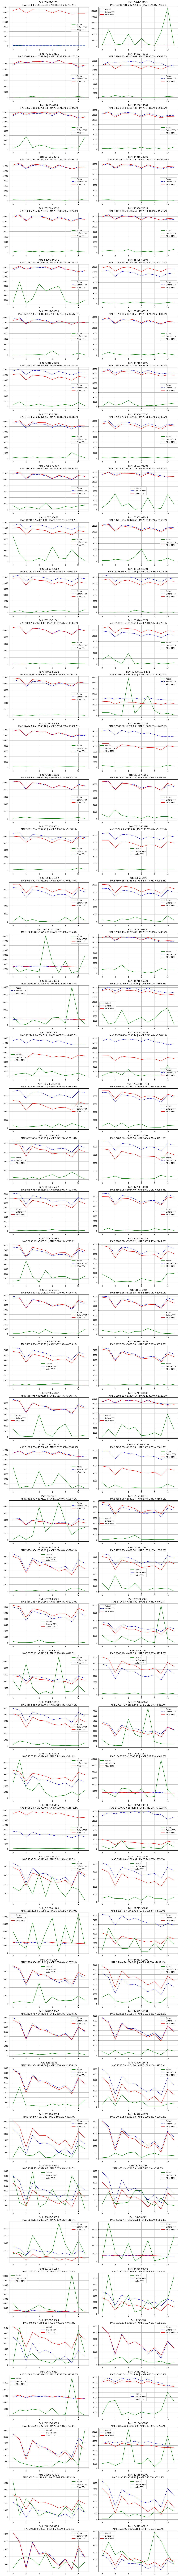

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def safe_inverse_expm1(arr, scaler, clip_min=-20, clip_max=20):
    # 스케일러 역변환
    arr_inv = scaler.inverse_transform(arr)
    # clip 적용 (log 값 제한)
    arr_clipped = np.clip(arr_inv, clip_min, clip_max)
    # expm1로 복원
    return np.expm1(arr_clipped)

# ✅ 샘플 개수 설정
n_samples = min(100, results_df.height)  # Polars에서는 height 사용
n_cols = 2
n_rows = (n_samples + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows), sharex=False)
axes = axes.flatten()

for i in range(n_samples):
    part_id = results_df["part_id"][i]
    y_true = results_df["actual"][i]  # ✅ Polars는 리스트 컬럼을 그대로 반환
    y_pred_before = results_df["predicted_before"][i]
    y_pred_after = results_df["predicted_after"][i]

    # ✅ numpy 변환
    # y_true = np.array(y_true, dtype=float).reshape(1, -1)
    # y_true_log = scaler_y.inverse_transform(y_true).flatten()
    # # y_true = np.expm1(y_true_log)
    #
    # y_pred_before = np.array(y_pred_before, dtype=float).reshape(1, -1)
    # y_pred_before_log = scaler_y.inverse_transform(y_pred_before).flatten()
    # # y_pred_before = np.expm1(y_pred_before_log)
    #
    # y_pred_after = np.array(y_pred_after, dtype=float).reshape(1, -1)
    # y_pred_after_log = scaler_y.inverse_transform(y_pred_after).flatten()
    # # y_pred_after = np.expm1(y_pred_after_log)
    # ✅ numpy 변환 + 역변환 (log 없음)
    y_true = scaler_y.inverse_transform(np.array(y_true, dtype=float).reshape(1, -1)).flatten()
    y_pred_before = scaler_y.inverse_transform(np.array(y_pred_before, dtype=float).reshape(1, -1)).flatten()
    y_pred_after = scaler_y.inverse_transform(np.array(y_pred_after, dtype=float).reshape(1, -1)).flatten()


    # ✅ Metrics
    mae_before = mean_absolute_error(y_true, y_pred_before)
    mae_after = mean_absolute_error(y_true, y_pred_after)
    mape_before = mean_absolute_percentage_error(y_true, y_pred_before)
    mape_after = mean_absolute_percentage_error(y_true, y_pred_after)

    # ✅ Plot
    ax = axes[i]
    horizon_range = range(len(y_true))
    ax.plot(horizon_range, y_true, label='Actual', color='green')
    ax.plot(horizon_range, y_pred_before, label='Before TTM', color='blue', linestyle='dashed')
    ax.plot(horizon_range, y_pred_after, label='After TTM', color='red', linestyle='solid')

    ax.set_title(
        f"Part: {part_id}\nMAE {mae_before:.2f}->{mae_after:.2f} | "
        f"MAPE {mape_before*100:.1f}%->{mape_after*100:.1f}%"
    )
    ax.legend()
    ax.grid(True)
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(False)

# ✅ 남은 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
